# In the name of God.

# EfficientNet V2L

In [ ]:
!pip install tensorflow matplotlib numpy pandas kaggle

In [ ]:
from google.colab import files

# Upload the kaggle.json file
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
import os
import shutil

# Create .kaggle directory
!mkdir -p ~/.kaggle
shutil.move("kaggle.json", "/root/.kaggle/")

# Set correct permissions
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
# Install required libraries
!pip install gdown tensorflow

# Download dataset for training on Food 101

In [ ]:
!ls -l

total 4
drwxr-xr-x 1 root root 4096 Apr 17 13:36 sample_data


In [ ]:
# Install required libraries if not installed
!pip install tensorflow tensorflow_datasets

# Import necessary libraries
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

# Check TensorFlow version and GPU availability
print("TensorFlow Version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow Version: 2.18.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os

tfrecord_path = "food101_dataset.tfrecord"

# Check if TFRecord already exists
if os.path.exists(tfrecord_path):
    print("TFRecord dataset already exists. Skipping download and processing.")
else:
    dataset_name = "food101"
    (ds_train, ds_test), ds_info = tfds.load(dataset_name, split=["train", "validation"], as_supervised=True, with_info=True)

    def _serialize_example(image, label):
        feature = {
            "image": tf.train.Feature(bytes_list=tf.train.BytesList(value=[tf.io.encode_jpeg(image).numpy()])),
            "label": tf.train.Feature(int64_list=tf.train.Int64List(value=[label]))
        }
        example = tf.train.Example(features=tf.train.Features(feature=feature))
        return example.SerializeToString()

    # Initialize the TFRecord writer
    with tf.io.TFRecordWriter(tfrecord_path) as writer:
        count = 0
        # Iterate through the dataset and write each example to the TFRecord file
        for image, label in ds_train:
            writer.write(_serialize_example(image, label))
            count += 1
            if count % 1000 == 0:  # Save every 1000 examples
                print(f"Processed {count} images...")

    print("TFRecord dataset saved successfully.")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.OWBFQF_2.0.0/food101-train.tfrecord*...:   0%|         …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.OWBFQF_2.0.0/food101-validation.tfrecord*...:   0%|    …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.
Processed 1000 images...
Processed 2000 images...
Processed 3000 images...
Processed 4000 images...
Processed 5000 images...
Processed 6000 images...
Processed 7000 images...
Processed 8000 images...
Processed 9000 images...
Processed 10000 images...
Processed 11000 images...
Processed 12000 images...
Processed 13000 images...
Processed 14000 images...
Processed 15000 images...
Processed 16000 images...
Processed 17000 images...
Processed 18000 images...
Processed 19000 images...
Processed 20000 images...
Processed 21000 images...
Processed 22000 images...
Processed 23000 images...
Processed 24000 images...
Processed 25000 images...
Processed 26000 images...
Processed 27000 images...
Processed 28000 images...
Processed 29000 images...
Processed 30000 images...
Processed 31000 images...
Processed 32000 images...
Processed 33000 images...
Processed 34000 images...
Pr

In [ ]:
# Load dataset from the TFRecord file
def _parse_function(proto):
    # Define the features you expect in the TFRecord file
    keys_to_features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # Encoded image
        "label": tf.io.FixedLenFeature([1], tf.int64)  # Label
    }

    # Load and parse the example
    parsed_features = tf.io.parse_single_example(proto, keys_to_features)

    # Decode the image
    image = tf.io.decode_jpeg(parsed_features['image'])


#     # Ensure images are resized to (224, 224)
# def preprocess_image(image, label):
#     # Resize images to (224, 224)
#     image = tf.image.resize(image, (224, 224))  # Resize to 224x224
#     image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
#     return image, label

#    # Ensure images are resized to (600, 600) for EfficientNetB7
# def preprocess_image(image, label):
#     image = tf.image.resize(image, (600, 600))  # Resize to 600x600
#     image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
#     return image, label

def preprocess_image(image, label):
    image = tf.image.resize(image, (448, 448))  # Reduce size to 448x448
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    return image, label

#     # Apply preprocessing to train and test datasets
# train_ds = ds_train.map(preprocess_image).batch(32).prefetch(tf.data.AUTOTUNE)
# test_ds = ds_test.map(preprocess_image).batch(32).prefetch(tf.data.AUTOTUNE)



# Apply preprocessing to train and test datasets
train_ds = ds_train.map(preprocess_image).batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = ds_test.map(preprocess_image).batch(32).prefetch(tf.data.AUTOTUNE)


    # Check the first batch shape to verify
for images, labels in train_ds.take(1):
  print(images.shape, labels.shape)

(32, 448, 448, 3) (32,)


# EfficientNet V2L

In [ ]:
# =============================================================================

import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2L
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Load EfficientNetV2L without the top classification layer
base_model = EfficientNetV2L(weights="imagenet", include_top=False, input_shape=(448, 448, 3))

# Freeze all layers initially
base_model.trainable = False

# Add custom classification head
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(101, activation='softmax')(x)

# Final model
model = Model(inputs=base_model.input, outputs=x)

# Unfreeze the base model for fine-tuning
base_model.trainable = True

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adamax(learning_rate=0.00005),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


# Callbacks
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=3)
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True)
#
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_accuracy", mode="max")

# Train the model
#history = model.fit(train_ds, validation_data=test_ds, epochs=20, callbacks=[reduce_lr, early_stop])
#
history = model.fit(train_ds, validation_data=test_ds, epochs=20, callbacks=[reduce_lr, early_stop, checkpoint])

473176280/473176280 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 1666s 567ms/step - accuracy: 0.2196 - loss: 3.6821 - val_accuracy: 0.7350 - val_loss: 1.0773 - learning_rate: 5.0000e-05
Epoch 2/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 1157s 489ms/step - accuracy: 0.6989 - loss: 1.2402 - val_accuracy: 0.8547 - val_loss: 0.5433 - learning_rate: 5.0000e-05
Epoch 3/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 1162s 491ms/step - accuracy: 0.8148 - loss: 0.7348 - val_accuracy: 0.8715 - val_loss: 0.4666 - learning_rate: 5.0000e-05
Epoch 4/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 1162s 491ms/step - accuracy: 0.8810 - loss: 0.4771 - val_accuracy: 0.8765 - val_loss: 0.4590 - learning_rate: 5.0000e-05
Epoch 5/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 1162s 491ms/step - accuracy: 0.9231 - loss: 0.3088 - val_accuracy: 0.8800 - val_loss: 0.4681 - learning_rate: 5.0000e-05
Epoch 6/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 1161s 490ms/step - accuracy: 0.9492 - loss: 0.2065 - val_accuracy: 0.8815 - val_loss: 0.47

In [ ]:
# ********************************
# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_ds)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

790/790 ━━━━━━━━━━━━━━━━━━━━ 97s 123ms/step - accuracy: 0.8795 - loss: 0.4563
Test Loss: 0.45898813009262085
Test Accuracy: 0.8765148520469666


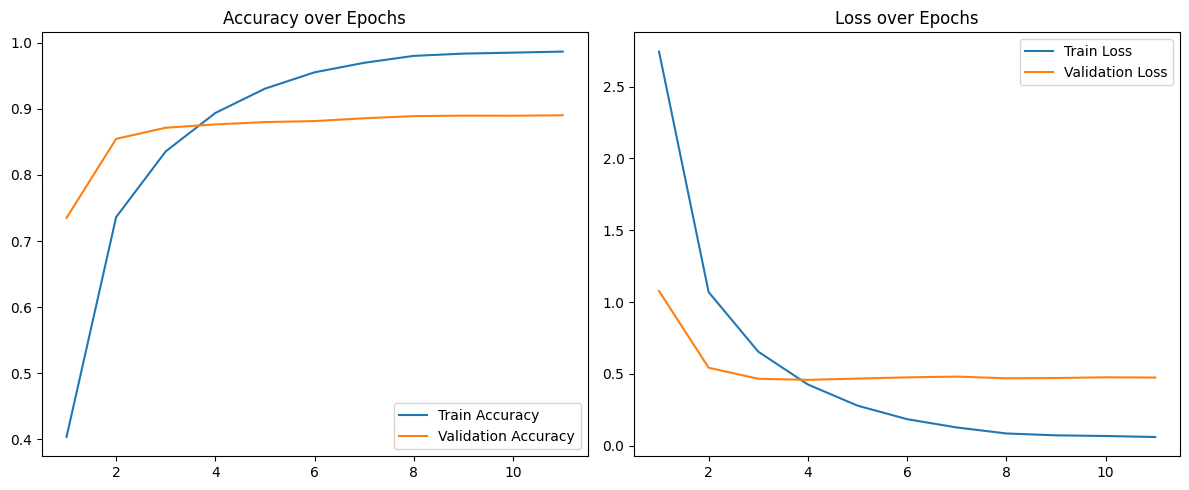

In [ ]:
import matplotlib.pyplot as plt

# Extract values from history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(acc) + 1)

# Plot accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy over Epochs')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Loss over Epochs')

plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score
import numpy as np
import tensorflow as tf

# ---------- TTA Functions ----------
def apply_tta(image):
    tta_images = [
        image,
        tf.image.flip_left_right(image),
        tf.image.adjust_brightness(image, 0.1),
        tf.image.adjust_contrast(image, 1.2),
    ]
    return tta_images

def predict_with_tta(model, dataset):
    y_true = []
    y_pred = []

    for images, labels in dataset:
        for i in range(images.shape[0]):
            original = images[i]
            tta_versions = apply_tta(original)
            tta_batch = tf.stack(tta_versions)
            preds = model.predict(tta_batch, verbose=0)
            avg_pred = tf.reduce_mean(preds, axis=0)
            predicted_label = tf.argmax(avg_pred).numpy()

            y_true.append(labels[i].numpy())
            y_pred.append(predicted_label)

    return np.array(y_true), np.array(y_pred)

# ---------- Step 1: Accuracy of final model (simple evaluation) ----------
simple_loss, simple_acc = model.evaluate(test_ds, verbose=0)
print(f"Simple Evaluation Accuracy (no TTA): {simple_acc:.4f}")

# ---------- Step 2: TTA accuracy of final model ----------
print("\n Running TTA on the final model...")
y_true_final, y_pred_final = predict_with_tta(model, test_ds)
tta_acc_final = accuracy_score(y_true_final, y_pred_final)
print(f"TTA Accuracy (final model): {tta_acc_final:.4f}")

# ---------- Step 3: TTA accuracy of best_model.keras ----------
print("\n Running TTA on best_model.keras...")
best_model = load_model("best_model.keras")
y_true_best, y_pred_best = predict_with_tta(best_model, test_ds)
tta_acc_best = accuracy_score(y_true_best, y_pred_best)
print(f"TTA Accuracy (best_model.keras): {tta_acc_best:.4f}")

# ---------- Step 4: Compare & Save the Best Performing Model ----------
print("\n Comparing all three accuracy metrics...")
print(f"Simple Accuracy:              {simple_acc:.4f}")
print(f"TTA Accuracy (final model):   {tta_acc_final:.4f}")
print(f"TTA Accuracy (best_model.keras): {tta_acc_best:.4f}")

if simple_acc >= max(tta_acc_final, tta_acc_best):
    print("\n Saving simple model (no TTA) as best model.")
    model.save("food101_trained_model.keras")
elif tta_acc_final >= tta_acc_best:
    print("\n Saving final model with TTA as best model.")
    model.save("food101_trained_model.keras")
else:
    print("\n Saving best_model.keras (with TTA) as best model.")
    best_model.save("food101_trained_model.keras")

Simple Evaluation Accuracy (no TTA): 0.8765

 Running TTA on the final model...
TTA Accuracy (final model): 0.8804

 Running TTA on best_model.keras...
TTA Accuracy (best_model.keras): 0.8941

 Comparing all three accuracy metrics...
Simple Accuracy:              0.8765
TTA Accuracy (final model):   0.8804
TTA Accuracy (best_model.keras): 0.8941

 Saving best_model.keras (with TTA) as best model.


# Capturing Food image from Webcam

In [ ]:
# from IPython.display import display, Javascript
# from google.colab.output import eval_js
# from base64 import b64decode
# import cv2
# import numpy as np

# def take_photo(filename='photo.jpg', quality=0.8):
#     js = Javascript('''
#         async function takePhoto(quality) {
#             const div = document.createElement('div');
#             const video = document.createElement('video');
#             const btn = document.createElement('button');
#             btn.textContent = 'Capture';
#             div.appendChild(video);
#             div.appendChild(btn);
#             document.body.appendChild(div);

#             const stream = await navigator.mediaDevices.getUserMedia({video: true});
#             video.srcObject = stream;
#             await video.play();

#             await new Promise((resolve) => btn.onclick = resolve);
#             const canvas = document.createElement('canvas');
#             canvas.width = video.videoWidth;
#             canvas.height = video.videoHeight;
#             canvas.getContext('2d').drawImage(video, 0, 0);
#             stream.getTracks().forEach(track => track.stop());
#             div.remove();

#             return canvas.toDataURL('image/jpeg', quality);
#         }
#     ''')
#     display(js)
#     data = eval_js('takePhoto({})'.format(quality))
#     _, encoded = data.split(',', 1)
#     img = b64decode(encoded)

#     with open(filename, 'wb') as f:
#         f.write(img)

#     #
#     img_np = cv2.imdecode(np.frombuffer(img, np.uint8), cv2.IMREAD_COLOR)
#     return img_np

# #
# img = take_photo()

# #
# import matplotlib.pyplot as plt
# plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
# plt.axis('off')
# plt.show()

# Uploading Food Image from Computer

# aproximate callories based on image of food

Saving download.jpg to download.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step
Enter weight of the food in grams (or press Enter to estimate automatically): 
No weight entered. Estimated weight: 147.0 grams


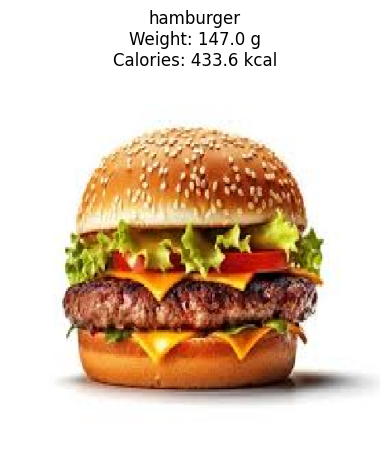

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import cv2
from google.colab import files

# ---------- Load Model ----------
model = tf.keras.models.load_model('/content/food101_trained_model.keras')

# ---------- Class Labels and Calories ----------
food_calories = {
    "apple_pie": 296, "baby_back_ribs": 400, "baklava": 334, "beef_carpaccio": 150, "beef_tartare": 195,
    "beet_salad": 75, "beignets": 250, "bibimbap": 600, "bread_pudding": 280, "breakfast_burrito": 305,
    "bruschetta": 170, "caesar_salad": 180, "cannoli": 230, "caprese_salad": 150, "carrot_cake": 360,
    "ceviche": 120, "cheese_plate": 320, "cheesecake": 320, "chicken_curry": 210, "chicken_quesadilla": 330,
    "chicken_wings": 430, "chocolate_cake": 350, "chocolate_mousse": 225, "churros": 250, "clam_chowder": 201,
    "club_sandwich": 400, "crab_cakes": 240, "creme_brulee": 290, "croque_madame": 350, "cup_cakes": 280,
    "deviled_eggs": 120, "donuts": 240, "dumplings": 250, "edamame": 122, "eggs_benedict": 300, "escargots": 200,
    "falafel": 330, "filet_mignon": 275, "fish_and_chips": 500, "foie_gras": 450, "french_fries": 312,
    "french_onion_soup": 250, "french_toast": 310, "fried_calamari": 300, "fried_rice": 238, "frozen_yogurt": 110,
    "garlic_bread": 206, "gnocchi": 250, "greek_salad": 150, "grilled_cheese_sandwich": 360, "grilled_salmon": 206,
    "guacamole": 230, "gyoza": 220, "hamburger": 295, "hot_and_sour_soup": 90, "hot_dog": 290, "huevos_rancheros": 220,
    "hummus": 166, "ice_cream": 207, "lasagna": 280, "lobster_bisque": 210, "lobster_roll_sandwich": 340,
    "macaroni_and_cheese": 310, "macarons": 140, "miso_soup": 40, "mussels": 86, "nachos": 346, "omelette": 154,
    "onion_rings": 275, "oysters": 70, "pad_thai": 375, "paella": 240, "pancakes": 227, "panna_cotta": 250,
    "peking_duck": 337, "pho": 290, "pizza": 266, "pork_chop": 231, "poutine": 330, "prime_rib": 400,
    "pulled_pork_sandwich": 415, "ramen": 440, "ravioli": 220, "red_velvet_cake": 360, "risotto": 280,
    "samosa": 262, "sashimi": 200, "scallops": 112, "seaweed_salad": 70, "shrimp_and_grits": 250,
    "spaghetti_bolognese": 350, "spaghetti_carbonara": 360, "spring_rolls": 120, "steak": 271,
    "strawberry_shortcake": 290, "sushi": 200, "tacos": 250, "takoyaki": 310, "tiramisu": 240, "tuna_tartare": 170,
    "waffles": 310
}


class_labels = list(food_calories.keys())

# ---------- Functions ----------
def upload_image():
    print("Please upload a food image:")
    uploaded = files.upload()
    filename = list(uploaded.keys())[0]
    new_filename = "food_image.jpg"
    with open(new_filename, "wb") as f:
        f.write(uploaded[filename])
    return new_filename

def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(448, 448))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    return x / 255.0, img

def predict_food(image_array):
    predictions = model.predict(image_array)
    index = np.argmax(predictions)
    return class_labels[index]

def estimate_food_weight(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        return 150  # Default weight if no contours found

    largest_contour = max(contours, key=cv2.contourArea)
    area = cv2.contourArea(largest_contour)
    estimated_weight = area * 0.1
    return min(max(estimated_weight, 50), 500)  # Bound between 50g and 500g

def show_result(img, food_name, weight, calories):
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'{food_name}\nWeight: {weight:.1f} g\nCalories: {calories:.1f} kcal')
    plt.show()

# ---------- Main Process ----------
img_path = upload_image()
x, original_img = preprocess_image(img_path)
predicted_food = predict_food(x)

# ---------- Weight Input or Estimation ----------
user_weight = input(f"Enter weight of the food in grams (or press Enter to estimate automatically): ")

if user_weight.strip().isdigit():
    food_weight = float(user_weight)
else:
    food_weight = estimate_food_weight(img_path)
    print(f"No weight entered. Estimated weight: {food_weight:.1f} grams")

# ---------- Calculate Calories ----------
calories_per_100g = food_calories.get(predicted_food, 200)
total_calories = (food_weight / 100) * calories_per_100g

# ---------- Show Final Result ----------
show_result(original_img, predicted_food, food_weight, total_calories)